In [1]:
import numpy as np
from scipy.linalg import eigh_tridiagonal

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

In [2]:
def get_H(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    T_ = -(np.diag(np.full(n-3,1),k=-1) + np.diag(np.full(n-2,-2),k=0) + np.diag(np.full(n-3,1),k=1))/2/h**2
    V_ = np.diag(V(x[1:-1]))
    H  = T_ + V_
    
    return x,H

In [3]:
def solve_SE(x0,x1,n,V):
    # x,H   = get_H(x0,x1,n,V)
    # E,psi = np.linalg.eigh(H)
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    d = -0.5/h**2*np.full(n-2,-2) + V(x[1:-1])
    e = -0.5/h**2*np.full(n-3,1)
    
    E,psi = eigh_tridiagonal(d,e)
    psi   = np.vstack(([np.zeros(E.shape[0]),psi,np.zeros(E.shape[0])]))
    return x,E,psi.T

# Finite square well

-- to do: comparison with analytic solutions (transcendental equation for even/odd solutions, how many solutions exist)

In [35]:
def V(t,a=1,V0=1):
    temp = -V0*(np.abs(t) < a).astype(float)
    return temp

In [49]:
x,E,psi = solve_SE(-5,5,1000,lambda t: V(t,a=2,V0=4))

In [66]:
E[:10]

array([-3.77829546, -3.12145131, -2.06126498, -0.6989058 ,  0.35251844,
        0.57779458,  1.10934297,  1.93612276,  2.50467792,  3.53564941])

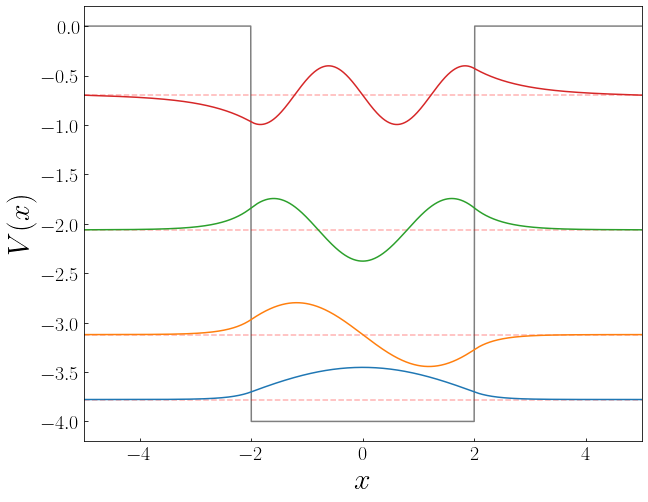

In [79]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_,a=2,V0=4),color='k',alpha=0.5)


ax.axhline(E[0],color='r',ls='--',alpha=0.3)
ax.plot(x,5*psi[0] + E[0])

ax.axhline(E[1],color='r',ls='--',alpha=0.3)
ax.plot(x,5*psi[1] + E[1])

ax.axhline(E[2],color='r',ls='--',alpha=0.3)
ax.plot(x,5*psi[2] + E[2])

ax.axhline(E[3],color='r',ls='--',alpha=0.3)
ax.plot(x,5*psi[3] + E[3])

ax.set_xlim(-5,5)
ax.set_xlabel(r'$x$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')

plt.show()

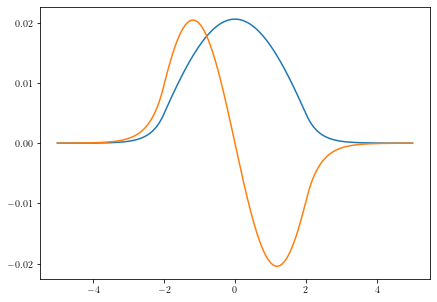

In [40]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

ax.plot(x,psi[0])
ax.plot(x,psi[1])
# ax.plot(x,psi[2])
# ax.plot(x,psi[3])
# ax.plot(x,psi[4])

plt.show()